<a href="https://colab.research.google.com/github/ilhamimutlu/GitHub-Projects/blob/main/Deep_Learning_NLP_Hepsi_Burada_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](attachment:image.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine Tuning For BERT Models with TPU

In [ ]:
# TensorFlow kütüphanesini içe aktar
import tensorflow as tf
# İşletim sistemi kütüphanesini içe aktar
import os

# Colab için özel bir adres olan tpu argümanını kullanarak TPUClusterResolver nesnesi oluştur
# Bu nesne, uzak TPU kümesine bağlanmak için gerekli olan koordinatları sağlar
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# TPU kümesine bağlanmak için tf.config modülünü kullan
tf.config.experimental_connect_to_cluster(resolver)
# TPU sistemini başlatmak için tf.tpu modülünü kullan
# Bu adım, TPU cihazlarını yapılandırır ve bellekleri temizler
tf.tpu.experimental.initialize_tpu_system(resolver)
# TPU kümesindeki tüm cihazları listelemek için print fonksiyonunu kullan
print("All devices: ", tf.config.list_logical_devices('TPU'))


TPU' yu bir degiskene atadik, modelleri calistirirken bunun altinda fonksiyonlar olusturup bu fonksiyonlari calistiracagiz. (Degiskene atamazsak TPU' nun hizindan faydalanamayiz). Ciktida da gordugumuz gibi 8 tane TPU cekirdegi tahsis edilmis :

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

BERT' in hazir modellerini kullanabilmek icin transformers' i install etmek gerekir :

Transformers, doğal dil işleme (NLP) alanında kullanılan bir kütüphanedir. Transformers kütüphanesi, çeşitli dil modellerini içerir. Bu modellerden biri de BERT'tir. BERT, Bidirectional Encoder Representations from Transformers'ın kısaltmasıdır. BERT, etiketlenmemiş metinlerden derin çift yönlü temsiller öğrenmek için tasarlanmış bir dil modelidir¹. BERT, hem sol hem de sağ bağlama göre tüm katmanlarda ortaklaşa koşullanarak, arama sorgularını ve dil anlayışını geliştirmek için kullanılabilir². BERT, 2018 yılında Google tarafından geliştirilmiştir³.

In [ ]:
!pip install transformers

## Import Library

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Bir onceki notebook' ta 'hepsiburada' corpusu ile GRU modeli kurmustuk, bu notebook' ta ise ayni corpus ile BERT model kuracagiz :

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DeepLearning/NLP/hepsiburada.csv", encoding="utf-8")

In [ ]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [ ]:
df.Rating.value_counts()

1    229821
0     13676
Name: Rating, dtype: int64

Hedef class olan olumsuz yorumlari map fonksiyonu ile 1 yaptik. (Binary modellerde loss ve recall degerleri 1 class' ina ait skorlari verir) :

In [ ]:
df.Rating = df.Rating.map({1:0, 0:1})

In [ ]:
df.Rating.value_counts()

0    229821
1     13676
Name: Rating, dtype: int64

Target label ile feature' i ayirip X ve y degiskenlerine atadik :

In [ ]:
X = df['Review'].values
y = df['Rating'].values

## Tokenization

### Fixing token counts of all documents

__Asagidaki islem ile butun cumlelerde gecen tokenleri sayip her yorum icin sabit bir token sayisi belirleyerek, her yorumdan %95 veya uzerinde basariyla token alma islemi yapacagiz  :__

BERT modellerindeki ilk asama, modele verilecek olan text' lerin boyutlarini belirlemektir.

Asagidaki islemde Tokenization islemi icin oncelikle transformers' tan AutoTokenizer' i import ettik. Bazi kaynaklarda BertTokenizer gibi farkli isimler de gorebiliriz fakat AutoTokenizer hepsini kapsar.

Hangi dilde calisacaksak __huggingface.co__ sayfasindan kodu kopyalayip __AutoTokenizer.from_pretrained__ icine yazmamiz gerekir. Bunu bir degiskene atadik.

__"dbmdz/bert-base-turkish-cased" :__ 'cased' yaziyorsa buyuk ve kucuk harfler var demektir. Ozellikle translate islemlerinde buyuk-kucuk harfler onemlidir. __uncased__ yazarsa hepsini kucuk harf yapar. Biz kucuk harf istiyoruz fakat 'uncased' sectigimizde Turkce karakterler secili olmadigi icin once 'case' yaptik, daha sonra for dongusu icinde __lower()__ ile kucuk harflere dönüstürme islemini manuel olarak  yaptik.

__max_len__ uzunlugunu 0 ile baslattik.

for dongusu ile butun yorumlari teker teker aldik, __tokenizer.encode__ islemi ile her cumleyi tokenlerine ayirdik.

__add_special_tokens=True :__ Cumlenin basina ve sonuna cumlenin nerede basladigini ve bittigini gosteren ozel tokenleri ilave eder. (__[CLS :__ Nerede basladigi; __[SEP] :__ Nerede bittigi)

encode ile butun yorumlari tokenlerine ayirdiktan sonra __len()__ ile bu tokenlerin boyutlarini saydirip max_token listesinin icine atacak.

max_len=0 ile baslatmistik. Her yapilan islem sonucu yeni gelen cumlenin tokenleri sayilarak __len(input_ids)__ elde mevcut olan eski uzunluk __max_len__, max fonksiyonu icine girer ve max deger hangisi ise o alinir ve max_len her islemde guncellenmis olur. print(max_len) ile ciktida en uzun cumlenin 758 tokenden olustugunu goruyoruz.

__!__ BERT model en fazla 512 token alabilir __!__

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

max_len = 0

# For every sentence...
max_token = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(sent.lower(), add_special_tokens=True)
    max_token.append(len(input_ids))

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (758 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  758


Yukarida kurdugumuz for dongusu icindeki islemi bir ornekle aciklayalim.

Tokenizer islemi ile bir cumlenin tokenlerine ayrilmis hali (7 token olustu). Bu tokenlerine ayirma islemine __Word Piece Tokenization__ denir.

Eger __uncased__ kullansaydik bu 'Sükrü' kelimesini tokenlerine ayirmazdi, biz classification islemi yapacagimiz icin ayirip ayirmamasi onemli degil; zaten model bunlari birlestirip yeni anlam cikariyor.

Model, egitim asamasinda 'sen' '##tepe' '##li' tokenlerini tek bir Word Embedding' te birlestirerek bunlarin tek bir token oldugunu anlayacak.

BERT modeller kendisine verilen text' lerin her bir tokeninin sayisal degerlere donusturulmus halini (input_ids) ve cumlenin uzunlugunun (attention_mask) ne oldugu bilgisini ister. (Classification islemlerinde token_type_ids kullanilmaz).

Model kurmadan once her yorumdaki token sayisinin esitlenmesi gerekiyordu. Asagida bu islem hangi mantikta yapilmali, bir ornekle acikladik (NLP_4 notebook' unda aciklandi) :

In [ ]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) < 10)
print(sum(np.array(list) < 10))

[ True False  True  True False False]
3


Yukaridaki for dongusu ile max_token degiskeni icine butun yorumlarin kac tokenden olustugu bilgisini vermistik. Asagida bunlarin ortalamasini aldik. Corpusumuzdaki yorumlar ortalama olarak 36 tokenden olusuyormus :

In [ ]:
np.array(max_token).mean()

36.4837390193719

Deneme-yanilma yolu ile tum yorumlari 160 tokene sabitledigimizde  corpustaki bilginin %98' ini tutabiliyoruz :

In [ ]:
sum(np.array(max_token) < 160) / len(max_token)

0.9877000537994308

Butun yorumlari 160 token sayisina sabitlemek icin asagidaki transformation fonksiyonunu olusturduk.

Tanimladigimiz transformation fonksiyonu icine butun yorumlari (X) verdik.

Sequence boyutunu (160) bir degiskene atadik.

Satir sayisini (len(X)) bir degiskene atadik. (Corpus kac yorumdan olusuyor bilgisi)

__np.zeros__ icine satir sayisini (num_samples) ve her yorumun kac tokenden olusacagini (seq_len) tanimladik. np.zeros icine tanimlamamizin sebebi; 0' lardan olusan bir matris elde etmek.

Ornegin np.zeros(10,10) ile 10 satir ve 10 sutundan olusan 0' larla dolu bir matris elde edilir. (Daha sonra bu matris' lerdeki 0 degerleri for dongusu icinde doldurulacak).

Yukaridaki for dongusu icinde __encode__ ile token islemi yapmistik ve boylece her bir yorumun kac tokende sabitlenmesi gerektigini tespit etmistik. encode kullaninca tokenlerin aldiklari numaralari vermisti. Fakat BERT modeli kurarken datanin __input_ids__, __token_type_ids__ ve __attention_mask__ bilgileri alinarak modele verilmesi gerekiyor.  Bunlarin hepsini alabilmek icin __encode_plus__ kullanmak zorundayiz.

__!!!__ __token_type_ids__ classification islemlerinde kullanilmaz, translate, sonraki cumleyi tahmin etme gibi problemlerde kullanilir. Biz bu calismada classification islemi yapacagimiz icin bunu kullanmayacagiz __!!!__

In [ ]:
def transformation(X):
  # set array dimensions
  seq_len = 160
  num_samples = len(X)

  # initialize empty zero arrays
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))


  for i, phrase in enumerate(X):
      tokens = tokenizer.encode_plus(phrase.lower(), max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True)
      # assign tokenized outputs to respective rows in numpy arrays
      Xids[i, :] = tokens['input_ids']
      Xmask[i, :] = tokens['attention_mask']
  return Xids, Xmask

Yukaridaki fonksiyonun icine __X__' i verdigimizde modele verecegimiz inputlar olan Xids ve Xmask matrisleri belirlenen boyutlarda olustu :

In [ ]:
Xids, Xmask = transformation(X)

In [ ]:
Xids.shape     # satir sayisi ve token uzunlugu

(243497, 160)

In [ ]:
Xmask.shape

(243497, 160)

Asagidaki ornekte __encode_plus__ sonucu olusan input_ids, token_type_ids ve attention_mask yapilari gosterildi :

In [ ]:
sentence = "No pain no gain".lower()
tokens = tokenizer.encode_plus(sentence.lower(), max_length=20, truncation=True,
                                      padding='max_length', add_special_tokens=True)
print(tokens)

{'input_ids': [2, 7031, 9425, 1973, 7031, 10321, 1973, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
np.zeros((10, 10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

__Xids'__ ler numeric hale donusmus olan yorumlar :

In [ ]:
Xids

array([[2.0000e+00, 2.3000e+01, 5.1420e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.3000e+01, 5.1420e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.7820e+03, 3.1200e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+00, 3.8070e+03, 9.2500e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 3.1560e+03, 4.1650e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 1.6807e+04, 1.9870e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

__Xmask__ ile her yorumun gercek cumle uzunlugu belirlendi (1 degerleri toplanir, 160 tokene ulasmak icin doldurulmus olan kisimlar 0 sayisi ile temsil edilir) :

In [ ]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Xkids, yorumlarin sayisal hale donusturulmus halleri ve Xmax, her yorumun kac tokenden olustugunu gosteren veriler modele input olarak verilmek uzere hazir.

Siradaki islemde output kismini ayarlayacagiz.

Asagidaki ornek ile Tensorflow kutuphanesindeki __to_categorical__ fonksiyonunun calisma mantigini aciklayalim :

__l = np.array([1, 0, 2, 3, 4]) :__ 5 farkli unique label olsun. Bunu to_categorical icine verip yanina da kac sinif var ise bunu verdigimizde to_categorical, verilere gore category siniflarini ayarlar. Ilgili label hangi sayi ise o satirda o sayiyi 1, digerlerini 0 yapar :

BERT modellerinde labellama islemi bu sekilde yapilir.

In [ ]:
#from tensorflow.keras.utils import to_categorical

#l = np.array([1, 0, 2, 3, 4])
#to_categorical(l, 5)

Istisnai durum olarak, eger corpus binary ise asagidaki gibi __reshape__ ile 1 ve 0' lardan olusan matrisler haline dönüstürebiliriz. (Egitim maliyetini azaltmak adina binary modellerde tavsiye edilen budur) :

__reshape(-1,1) -->__ 1 : Tek sütun, -1 : Kac satir oldugunu kendisi tespit eder, yazmaya gerek yok. Bunun ile tek satirli matris olusur.

In [ ]:
np.array([1, 0, 1, 0, 0]).reshape(-1,1) #reshape(5,1)

array([[1],
       [0],
       [1],
       [0],
       [0]])

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

y, 0 ve 1' lerden olusan bir array idi. Bu degerleri reshape ile one-hot encoding sekline dönüstürdük. (Sadece 2 class oldugu icin reshape yontemini kullandik). (y, bir sutundan olusan matrise donustu)  :

In [ ]:
labels = y.reshape(-1,1)
labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Yukaridaki islemler ile inputlar icin her bir tokenin numeric hale dönüstürülmüs hali olan Xids, her bir yorumun kac tokenden olustugunu gosteren Xmask, ve label' lar (y) matris haline dönüstürülmüs oldu. Bunlari matrise dönüstürmemizin sebebi; bunlari sonraki islemde __tensor'__ e dönüstürecegiz.  

__tensor :__ Birden fazla matristen olusan düzenektir. Burada 3 tane matris var; Xids, Xmask, label. Olusturdugumuz inputlari ve labeli tensor icine vererek bunlari modelin istedigi bicime donusturecegiz.

__tf.data.Dataset.from_tensor_slices :__ Islemi ile BERT modele verebilmek icin datasetimizi uygun formata getiriyoruz. Fakat oncesinde bunu tensor'e dönüstürmeliyiz.

__from_tensor_slices :__ Xids, Xmask ve labels' i matrislerin her birini ayri ayri modele verir. Ciktisinda da goruldugu gibi, Xids ve Xmask' in tek satirli 160 dizinden olusuyor; labels ise bir token ve bir satirdan olusuyor.

Bazi kaynaklarda _from_tensor_slices_ yerine _from_tensors_ kullanildigini goruruz. Bu, butun matrisin oldugu gibi modele verilecegi anlamina gelir(160, satir sayisi) ve model calismaz. Bu yuzden her model satir satir modele verilsin diye (160,) _from_tensor_slices_' i kullaniyoruz.

In [ ]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels)) #tf.data.Dataset.from_tensors((Xids, Xmask, labels))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

Yukaridaki islemlerden sonra model hala Xids, Xmask ve labels' tan hangisinin __input,__ hangisinin __output__ oldugunu bilmiyor.Bunlari modele tanitmamiz gerekiyor.  __!!!__ Yukaridaki BERT model icinde gecen etiket isimleri ne ise bu isimleri kullanmak cok onemli (Xids, Xmask, labels) __!!!__

Bunun icin asagida bir fonksiyon yazdik. Fonksiyonun icine Xids, Xmask ve labels' i tanimladik ve input_ids ve attention_mask' i dictionary icinde verdik. __!!!__ Bunlari dictionary icine yazmak cok onemli, bu sekilde model input ve output kismini ayirt edebiliyor (input ve output' u birbirinden ayirdik) __!!!__

dict icinde olanlar input, disarda kalan output tek basina oldugu icin bunu ayrica tanimlamamiza gerek yok, dict disina yazdik.

map fonksiyonu ile  bu islemleri uyguladik ve datamizi modele hazir hale getirdik.

In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

def map_func(Xids, Xmask, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

Input ve labellarin ne oldugu artik belli, modele bunu verdigimizde artik model input_ids' nin, attention_mask' in hangi tensor oldugunu ve disarda kalanin da output tensorü oldugunu bilecek :

In [ ]:
dataset

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

## Train Test Split

Datasetini BERT modelin anlayacagi sekle getirdikten sonra bunlari paketler haline getirme islemini yapacagiz.

NLP modellerinde train-test split islemleri DL modellerinden farklidir.

RNN modellerinde batch_size fit islemi esnasinda veriliyordu. BERT modellerinde ise dataseti olusturma asamasinda belirlenir.

__!!!__ Dokumanlara gore, BERT modellerde batch_size sadece 16 veya 32 olabilir. __!!!__

batch_size=16 sectigimizde model, overfite gittigi icin 32 degerini sectik.

__shuffle -->__ Datasetini kendi icinde karistirmamiz gerekiyor, bunun icin shuffle fonksiyonunu kullaniyoruz.

#### __shuffle Parametreleri :__

__buffer_size -->__ Dokumanlara gore, corpustaki satir sayisindan buyuk bir rakam yazilirsa datasetinin en iyi karisimi elde edilir. Bu yuzden satir sayimizdan daha buyuk bir sayi olan 243500' ü yazdik. Bu islem ile matrisler kendi icinde karistirilir, daha sonra bunlar train-test split isleminde ayrilacaklar.

__reshuffle_each_iteration=False -->__ Model kurulduktan sonra train ve test seti arasindaki overfitting durumunu kontrol edebilmek icin bu parametrenin __False__ olmasi gerekir. True secildiginde test set ve train seti egitim asamasinda her iterasyonda karisabilir. (Default=True)

__.batch -->__ Data karildiktan sonra batch' lere bolme islemi yapilir. Biz batch_size=32 sectigimiz icin 32' li paketlere bolunecekler.  

__drop_remainder=True -->__ Modelin kacli paketlere bölündügünü bilmesi icin bunu mutlaka __True__ secmek gerekir. Eger false dersek __TensorSpec(shape=(32, 160)__' taki 32 yerine NaN yazar ve kacli paketlere bölündügünü bilmez.

In [ ]:
batch_size = 32

# shuffle and batch
# fit into a batch of 32
dataset = dataset.shuffle(243500, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)

In [ ]:
dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 160), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32, 160), dtype=tf.float64, name=None)}, TensorSpec(shape=(32, 1), dtype=tf.int64, name=None))>

Her zaman yaptigimiz train-test split islemini burada uygulayamayiz. 'dataset' degiskeni icinde butun datamiz var. Bunun icinden train ve test setlerini birbirinden ayirmamiz gerekiyor.

BERT modellerinde train seti icin kullanilan oran genelde __%90'__ dir.

split isimli bir degiskene 0.9 sayisini atadik.

__len(dataset) -->__ dataset = satir sayisi / batch_size uzunlugunda (243497 / 32 = 7609). Datasetindeki satirlari 32' li paketlere boldugumuz icin datasetimizin uzunlugu artik 7609. Yani 7609 tane 32' li paketimiz var.

7609 tane olan datasetini 0.9 ile carparak datanin %90' ini train islemi icin ayiracagiz. Bunu size isimli bir degiskene attik ve int' e donusturduk (Cunku küsuratli bir sayi cikiyor.)

In [ ]:
Xids.shape

(243497, 160)

In [ ]:
#batch_size=32
int(Xids.shape[0]/batch_size)

7609

In [ ]:
print(len(dataset))
print(len(dataset)*0.9)
print(int(len(dataset)*0.9))

7609
6848.1
6848


__dataset.take(size) :__ Datasetinden size kadarini al (%90) (train datasi)

__dataset.skip(size) :__ Geriye kalanlari al (%10) (validation datasi)

Train ve validation datasetlerinin icinde hem inputlar, hem de outputlar var. Bu yuzden X_train y_train islemine gerek yok. X_train (input) ve y_train (output) datasetinin icinde tanimli.

In [ ]:
# set split size (90% training data) and calculate training set size
split = 0.9
size = int(len(dataset)*split) #int((Xids.shape[0]/batch_size)*split)

# get training and validation sets
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

## Adamw optimization

Optimization, loss degerini minimize etmeye calisan bir algoritmadir.

BERT modellerinin cok iyi skorlar almasinin bir nedeni de __Adam weight__ optimizasyonunu kullanmasidir.

Optimizasyon islemi icin asagidaki kod install edilmeli :

In [ ]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.1 MB/s eta 0:00:00


In [ ]:
len(train_ds)

6848

Asagidaki kod, tensorflow' un dokumanlarinda yayinladigi koddur. Fakat bu kod cok fazla hata verdigi icin genelde klasik adam optimizer' i tercih edilir. Biz onerilen kodu kullanacagiz.

epoch sayisi bu asamada belirlenir.

Dokumanlara gore BERT modellerde __epoch__ sayisi mutlaka 1, 2 veya 3 olmali. Cunku 3' ten sonra modeller genelde overfite gider.

__steps_per_epoch = len(train_ds) -->__ Train datasetinde kac islem yapilacagi bilgisi. (32' li paketlerden kac tane var?)

__num_train_steps = steps_per_epoch * epochs -->__ Train setinin %90' i. (Amaci, %90' lik bu kisimdan bir skor alip %10' luk kisimdan (num_warmup_steps) aldigi kisimla karsilastirarak loss degerinin minimize olma islemini surekli olarak kontrol etmektir. (Egitim icinde egitim))

__num_warmup_steps = int(0.1*num_train_steps) -->__ Train setinin %10' u.

Belirledigimiz degiskenleri, __create_optimizer__ fonksiyonu icine verdik.

__init_lr -->__ Baslangic learning rate' i. Google dokumanlari learning rate icin 3 deger kullanilmasini onerir, bunlar; __2e-5, 3e-5, 5e-5__. Dokumanlara gore bu 3 degerden baska deger kullanilmamali. Bu degerler teker teker denenip en iyi skoru alinan deger tercih edilmeli.

In [ ]:
from official.nlp import optimization
epochs = 1  #2, 3
#batch_size = 32
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5  # 3e-5, 5e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

## Creating Model

__!!!__ TPU' yu kullanabilmek icin bunu mutlaka bir fonksiyon icinde import etmemiz gerekir. Yoksa TPU' nun hizindan faydalanamayiz ve hata verir __!!!__

Butun dillerdeki BERT modelleri icin __TFAutoModel__ import edilip kullanilabilir. (TFAutoModel : Tensorflow kutuphanesini kullanan BERT model)

tf' ten Input fonksiyonlarini kullanarak inputlarimizi belirledik ve degiskenlere atadik :

__input_ids -->__ Yukarida datasetini olustururken input kismina tokenizer isleminde gecen isimleri vermemiz onemliydi. Ayni sekilde burda da modelin input id' yi taniyabilmesi icin __name__ kismina mutlaka bu isimleri belirtmeliyiz. __!__

BERT model 'dtype=int32' ile calisir. Bu yuzden bunlari int32' ye donusturduk.

__attention_mask -->__ Modelin bunun da bir input oldugunu anlayabilmesi icin __name__ kisminda bunu da belirtmemiz gerekir.

__shape=(160,) -->__ Token sayisini yukaridaki islemlerde 160 olarak belirlemistik. (Bu sayi BERT modellerde en faz 512 olabilir. Yazilan sayi buyudukce parametre sayisi da artar ve egitim uzar.)

__!__ BERT modelde Sequential tanimlamiyoruz. __!__

BERT modelin en son layer' i __pooler_output__' tir.

__pooler_output -->__ BERT modelin kendi icinde olusturdugu hazir Word Embeding' ler burda kayitlidir. Bu ozel egitilmis Word Embedding' ler pooler_output ile cekilerek Dense layer' a aktarilir. Bu sekilde yorumlar arasinda az gecen tokenler bile yuksek olasilikla tahmin edilir. __embeddings__ degiskeni icine model.bert ile inputlari ve koseli parantez icinde pooler_output' u verince, corpusta bulunan butun tokenlere ait Word Embedding' ler __Dense__ layer' a aktarildi.

X degiskeninin sonuna (embeddings) yazinca __add__ islemi yapilmis oldu. Boylece fully connected layere (Dense), embeddings' ten alinan Word Embedding degerleri aktarilmis oldu.

Corpusta cok az gecen tokenler bile BERT model ile buyuk olasiliklarla dogru tahmin edilir. Cunku BERT modeldeki tokenlerin Word Embedding degerleri milyarlarca kez egitilmistir.

embeddings degiskenindeki Word Embedding' ler Dense layer' a aktarilir. Dense layer icindeki sayi tercihe gore degistirilip skorlar takip edilebilir.

Dokumanlara gore __Dropout__ degerini 0.1 secmek tavsiye edilir. Bizim modelimiz overfit oldugu icin biz burda 0.2 sectik :

x degiskeninde Dense layer' a __embeddings__' i ekledik, sonra bir dropout layer tanimladik ve sonunda (x)' i yine ekledik ki x dropout' a tabi tutulsun. Son olarak da Droput' tan alinan degerler y' ye aktarilacak ve output alinacak.

Son olarak __return__ kisminda inputlari ve output' u (y) tanimladik. Bu sayede model, egitim asamasinda bunlari baz alarak loss degerlerini hesaplayacagini bilsin.

In [ ]:
def create_model():
    from transformers import TFAutoModel
    model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")
    input_ids = tf.keras.layers.Input(shape=(160,), name='input_ids', dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(160,), name='attention_mask', dtype='int32')

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]

    x = tf.keras.layers.Dense(160, activation='relu')(embeddings)
    x = tf.keras.layers.Dropout(0.2, name="dropout")(x)
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(x)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

TPU' yu kullanabilmek icin asagidaki islemi mutlaka yapmamiz gerekiyor. (Notebook basinda TPU' yu kullanabilmek icin strategy degiskenini olusturmustuk)

optimizer, loss, recall (accuracy takip edilmek isteniyorsa bu yazilabilir), create ettigimiz model fonksiyonu degiskenleri olusturulur ve bu degiskenler __compile__ icine yazilir. Bu sekilde modelimiz TPU icine tanimlanmis olur :

In [ ]:
with strategy.scope():

  optimizer = optimizer #tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
  loss = tf.keras.losses.BinaryCrossentropy()
  recall = tf.keras.metrics.Recall()
  model3 = create_model()
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

tf_model.h5:   0%|          | 0.00/545M [00:00<?, ?B/s]

Some layers from the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Yukarida TPU islemini yaptiktan sonra bir uyari veriyor. Classification islemlerinde bu uyariyi vermesi normal.

Biz modelimizde bir agirliklandirma yapmadik fakat yapmak istenirse asagidaki gibi class' larin corpusta bulunma yuzdelerine bakilip, tam tersi degerler birbirlerine yazilarak agirliklandirma islemi yapilabilir :

In [ ]:
#pd.Series(y).value_counts(normalize=True)

Agirliklandirma yapacak olsaydik asagidaki degiskeni fit islemi icine vermemiz gerekirdi :

In [ ]:
#weights = {0:0.05, 1:0.95}

Bu kadar dengesiz bir verisetinde bile BERT model ile skorlarimiz cok iyi oldugu icin ayrica agirliklandirma islemine pek ihtiyac duyulmaz.

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 160)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 160,                                           

__!!!__ BERT modellerde sadece class_weight kullanilir, sample_weight kullanilmaz. __!!!__

fit islemi icine train ve val datasini ve epoch sayisini verdik (Agirliklandirma yapilsaydi class_weight de verilebilirdi).

__!!__ Buradaki fit isleminde X_train ve y_train yok; train ve validation datasetinin icinde bunlar mevcut (Xids ve Xmask, X_train' dir; output ise y_train' dir).

In [ ]:
history = model3.fit(
    train_ds, validation_data= val_ds,
    epochs=epochs)

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7cb48c0a12d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7cb48c0a12d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6848/6848 [==============================] - ETA: 0s - loss: 0.0929 - recall: 0.6706

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7cb2fbb8a830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7cb2fbb8a830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6848/6848 [==============================] - 675s 88ms/step - loss: 0.0929 - recall: 0.6706 - val_loss: 0.0629 - val_recall: 0.7526


## Model evaluation

Modelimizi egittik, skorlarimizi alacagiz.

validation dataseti (val_ds), 32' li paketler halinde, bunu for dongusune sokmadan icerigini goremeyiz. Bu datanin icine girip gercek y degerlerini almamiz lazim ki egittigimiz modelden aldigimiz y degerleri ile gercek y degerlerini karsilastirabilelim.

__y_pred__ degiskenine modeldeki y degerlerini attik, for dongusu ile de gercek y degerlerine ulastik.

__i[0] -->__ val_los icindeki input degerleri var (Xids, Xmask)

__i[1] -->__ val_los icindeki output degeri (y)

Asagidaki for dongusu icinde array' e cevirme islemi yapmazsak tensor seklinde verir ve cok fazla yer kaplar, calisma hizi düser. array' e cevirmek islemi cok hizlandirdigi icin cevirdik.

Ilk for dongusu ile 32' lik paketlerin icine girmis olduk, icteki ikinci for dongusu ile ise icerdeki her bir class degerlerini y_test listesinin icine attik. Bu sekilde class' larin gercek degerlerini cekmis olduk. Sonrasinda bunlari __classification_report__ icine vererek skorlarimizi aldik :

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model3.predict(val_ds) >= 0.5

y_test = []
for i in val_ds:
  for j in np.array(i[1]):
    y_test.append(j)

print(classification_report(y_test, y_pred))

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7cb2fbe24e50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7cb2fbe24e50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
761/761 [==============================] - 23s 24ms/step


Exception ignored in: <function Executor.__del__ at 0x7cb4780b6290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23006
           1       0.86      0.75      0.80      1346

    accuracy                           0.98     24352
   macro avg       0.92      0.87      0.90     24352
weighted avg       0.98      0.98      0.98     24352



Yukarida validation icin yaptigimiz ayni islemi train datasi icin de yaparak skorlarimizi aldik ve train-test setlerinden alinan skorlari karsilastirma imkani bulduk.

Cok dengesiz bir veriseti ile BERT modelde mukemmel skorlar aldik (Ayni datasetiyle GRU ile aldigimiz skorlar cok dusuktu).

In [ ]:
y_train_pred = model3.predict(train_ds) >= 0.5

y_train = []
for i in train_ds:
  for j in np.array(i[1]):
    y_train.append(j)

print(classification_report(y_train, y_train_pred))

6848/6848 [==============================] - 144s 21ms/step


Exception ignored in: <function Executor.__del__ at 0x7cb4780b6290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    206808
           1       0.92      0.83      0.87     12328

    accuracy                           0.99    219136
   macro avg       0.95      0.91      0.93    219136
weighted avg       0.99      0.99      0.99    219136



In [ ]:
for i in val_ds:
  print(np.array(i[1]))      # validation datasinin yapisi
  break

[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


Agirliklandirma islemi yapsaydik asagidaki parametreleri kullanarak su skorlari alacaktik :

Modelin genel performansi GRU modelde %73 idi, BERT modelde %89 :

761/761 [==============================] - 19s 23ms/step


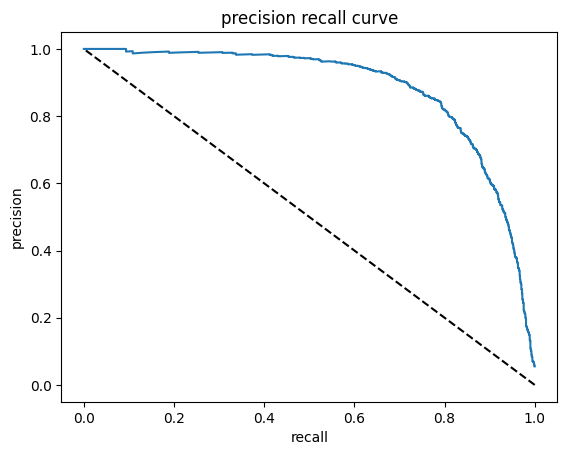

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model3.predict(val_ds)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

0.8823620228581432

Kurdugumuz modeli kaydettik :

In [ ]:
model3.save("sentiment_model_without_weighted.h5")

In [ ]:
!pip install -q tf-models-official

Adamw optimizer' in pek fazla tercih edilmedigini yukarida soylemistik. Bunun sebebi bu modeli kaydettikten sonra geri cagirirken hata alinmasi. Hata almamak icin yukaridaki __install__ isleminin mutlaka tekrar yapilmasi gerekir. Sonrasinda import islemlerini yaptiktan sonra model drive' a hangi isimle kaydedildiyse _load_model_ icine bu yazilir ve __custom_object__ asagida yazildigi sekilde eklenir, bu eklenmezse kaydedilen model tekrar load edilemez.

In [ ]:
import tensorflow as tf
import official.nlp.optimization as adamw
from tensorflow.keras.models import load_model


model4 = load_model('/content/sentiment_model_without_weighted.h5', custom_objects={'AdamWeightDecay':adamw.AdamWeightDecay})

ValueError: Unknown decay: 'WarmUp'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

Kaydettigimiz modeli lokalden tekrar cagirdik ve artik modelden tahminler alacagiz. Modele verecegimiz yorumlari modele uygun yapiya donusturmemiz gerekiyor. Bunun icin prediction alacagimiz datayi __prep_data__ fonksiyonu ile tanimladik ki yorumlari tokenlerine ayirip tensor formatina donusturebilelim. Buradaki islemin yukaridakinden tek farki, tokenizer.encode_plus icine __return_tensors='tf'__ da tanimlamamizdir. Bunun ile "Tensorflow formatinda tensor' a donustur" demis olduk. (tf yerine pt yazilirsa Pytorch formatina donusturur. Biz Tensorflow uzerinde calistigimiz icin tf olarak belirtmek zorundayiz).

Olusturdugumuz __prep_data__ fonksiyonu ile prediction icin verecegimiz yorumlarin hepsi input_ids ve attention_mask' e donusturulecek.

__return__ islemi ile inputlarin input_ids ve attention_mask' e donusturmesi icin komutu verdik.

In [ ]:
# initialize tokenizer from transformers
from transformers import AutoTokenizer, TFAutoModel

tokenizers = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizers.encode_plus(text.lower(), max_length=160,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True,
                                   return_tensors='tf')

    return {'input_ids': tokens['input_ids'],      #tf.cast(tokens['input_ids'], tf.int32)
            'attention_mask': tokens['attention_mask']} #tf.cast(tokens['attention_mask'], tf.int32)

Asagida modeli yaniltabilecek bircok prediction ornegi tanimladik.

Asagidaki yorumlarin hepsini reviews degiskeninin icine attik :

In [ ]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "bu kargoyu biran önce bırakın. yoksa üründe sıkıntı yok"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
review15 = "alınca anlarsın anyayı konyayı"
review16 = "çöpe atacak paran varsa alabilirsin"
review17= "Telefon fena değil"
review18 = "al da gününü gör"
review19 = "Ürün süper ama satıcı ve kargo berbat"
review20= "kargo süper ama ürün berbat"
review21 = "Aldigim TV cok kaliteli diye dusunmustum, sonradan cok da iyi bir TV olmadigini dusundum, ama neyse yine de memnunum."
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16, review17, review18, review19, review20, review21]

Asagidaki for dongusu ile : "reviews listesi icindeki her bir yorumu al, prep_data fonksiyonu icine atarak tensorler haline cevir, model4.predict ile bunlarin predictionlarini yap ve buldugun sonuclari probs listesine at." dedik.

__[0][0] -->__ predict islemi sonucu iki boyutlu array' ler olusuyor fakat biz sadece array icindeki skorlari almak istedigimiz icin indexleme islemi yapiyoruz.

In [ ]:
probs = []
for i in reviews:

  in_tensor = prep_data(i)

  prob = model3.predict(in_tensor)[0][0]

  probs.append(prob)

1/1 [==============================] - 1s 619ms/step


Asagida her bir yorum sonucu olusan olasilik degerleri var. 0' a yakin olanlar olumlu, 1' e yakin olanlar ise olumsuz yorumlar :

In [ ]:
probs

[0.0004786551,
 0.00063967705,
 0.9948493,
 0.0010980368,
 0.6820523,
 0.9941728,
 0.0013686419,
 0.988831,
 0.00042262673,
 0.9952968,
 0.00069886446,
 0.06503254,
 0.96416676,
 0.0027583241,
 0.004379809,
 0.03820783,
 0.11895338,
 0.0040067732,
 0.028638184,
 0.6524924,
 0.010313749]

0.5 degrinden kucuk olanlari 0 class' ina, buyuk olanlari 1 class' ina at :

In [ ]:
classes  = (np.array(probs) >= 0.5).astype("int")
classes

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

Predict icin verilen yorumlar olan review, predict islemi sonucu elde edilen olasilik degerleri olan prob ve bu prob' lardan elde edilen classes' lari bir dict icine atip DataFrame' e donusturduk :

In [ ]:
my_dict = {"Review":reviews, "prob":probs, "classes":classes}

__pd.set_option('display.max_colwidth', None) -->__ Yorumlari oldugu gibi gorebilmek icin kullandik. (None yerine -1 yazilabilir.)

Bazi yorumlari anlamak zor olmasina ragmen model cogu tahmini dogru bildi. Sadece corpus' ta hic gecmeyen kelimeleri tahmin edememis :

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.000479,0
1,süper ürün aynı gün elime geçti,0.000640,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.994849,1
3,kelimelerle tarif edilemez,0.001098,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.682052,1
5,hiç resimde gösterildiği gibi değil,0.994173,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler,0.001369,0
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.988831,1
8,tam bir fiyat performans ürünü,0.000423,0
9,beklediğim gibi çıkmadı,0.995297,1


![image.png](attachment:image.png)